## Υβριδικό Σύστημα Ανάκτησης


### Imports 

In [1]:
import os
# Ρύθμιση για FAISS στα Windows (Πρέπει να οριστεί πριν τα imports)
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import pandas as pd
import numpy as np
import faiss
import re
import html
import subprocess
from pathlib import Path
from tqdm import tqdm
from elasticsearch import Elasticsearch
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

CWD = Path.cwd()
DATA_DIR = CWD / "data"
RESULTS_DIR = CWD

DOCUMENTS_CSV = DATA_DIR / "documents.csv"
QUERIES_CSV = DATA_DIR / "queries.csv"
QRELS_FILE = DATA_DIR / "qrels.txt"
TREC_EVAL_PATH = CWD / "trec_eval" / "trec_eval.exe"

ES_HOST = "http://localhost:9200"
ES_INDEX = "ir2025_bm25"  # Το ίδιο index με τη Φάση 1
MODEL_NAME = 'all-MiniLM-L6-v2'  # Το ίδιο μοντέλο με τη Φάση 2

N_CANDIDATES = 200  # Αριθμός υποψηφίων από ElasticSearch
K_VALUES_RUN = [20, 30, 50]  # Τελικά k αποτελέσματα μετά το re-ranking
K_VALUES_EVAL = [5, 10, 15, 20]  # Τιμές k για evaluation metrics

print("Libraries loaded and paths configured.")

 Libraries loaded and paths configured.


In [ ]:
def clean_text(s: str) -> str:
    """Καθαρισμός κειμένου"""
    if s is None:
        return ""
    s = str(s)
    s = html.unescape(s)
    s = re.sub(r"[\x00-\x08\x0b\x0c\x0e-\x1f\x7f]+", " ", s)
    s = s.replace('\r', ' ').replace('\n', ' ')
    s = re.sub(r"\s+", " ", s).strip()
    return s


def get_es_candidates(es, index_name, query_text, n=200):
    """Ανάκτηση των top-N εγγράφων από το ElasticSearch"""
    try:
        resp = es.search(
            index=index_name,
            size=n,
            query={"match": {"text": clean_text(query_text)}}
        )
    except Exception as e:
        print(f"ElasticSearch error: {e}")
        return []
    
    candidates = []
    for hit in resp['hits']['hits']:
        c = {
            'doc_id': hit['_source']['doc_id'],
            'text': hit['_source'].get('text', ''),
            'es_score': hit['_score']
        }
        candidates.append(c)
    return candidates

print("Functions are defined.")

Function are defined.


### Σύνδεση με ElasticSearch

In [9]:
# Σύνδεση με ElasticSearch
es = Elasticsearch(ES_HOST, request_timeout=60)

if not es.ping():
    raise ConnectionError(f"Could not connect to ElasticSearch at {ES_HOST}. Make sure it is running!")
print("ElasticSearch connected.")

# Ελέγχουμε ότι το index υπάρχει
if not es.indices.exists(index=ES_INDEX):
    raise ValueError(f"Index '{ES_INDEX}' does not exist. Run Phase 1 first!")
print(f"Index '{ES_INDEX}' found.")

# Φόρτωση μοντέλου Transformer
print(f"\nLoading Transformer Model ({MODEL_NAME})...")
model = SentenceTransformer(MODEL_NAME)
print("Model loaded.")

# Φόρτωση ερωτημάτων
print(f"\nLoading queries from {QUERIES_CSV}")
df_queries = pd.read_csv(QUERIES_CSV)
print(f"Loaded {len(df_queries)} queries.")

ElasticSearch connected.
Index 'ir2025_bm25' found.

Loading Transformer Model (all-MiniLM-L6-v2)...


c:\Users\User\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Model loaded.

Loading queries from c:\Users\User\Downloads\IR2025\IR2025\data\queries.csv
Loaded 10 queries.


### Υβριδική αναζήτηση

In [ ]:
# Λεξικό για αποθήκευση αποτελεσμάτων ανά k
results_buffer = {k: [] for k in K_VALUES_RUN}
print(f"Starting Hybrid search (N={N_CANDIDATES} candidates per query)")

for idx, row in tqdm(df_queries.iterrows(), total=len(df_queries), desc="Processing Queries"):
    qid = row['ID']
    qtext = row['Text']
    candidates = get_es_candidates(es, ES_INDEX, qtext, n=N_CANDIDATES)
    if not candidates:
        print(f"Warning: No candidates found for query {qid}")
        continue
    candidate_texts = [clean_text(c['text']) for c in candidates]
    candidate_ids = [c['doc_id'] for c in candidates]
    
    # Δημιουργία Embeddings για το ερώτημα και τα N έγγραφα
    q_emb = model.encode([clean_text(qtext)], convert_to_numpy=True).astype('float32')
    doc_embs = model.encode(candidate_texts, convert_to_numpy=True).astype('float32')
    
    # Κανονικοποίηση για Cosine Similarity
    faiss.normalize_L2(q_emb)
    faiss.normalize_L2(doc_embs)
    
    # Δυναμικό FAISS Index για τα N έγγραφα
    d = doc_embs.shape[1] 
    index = faiss.IndexFlatIP(d)  
    index.add(doc_embs)
    
    # Αναζήτηση στο FAISS - Re-ranking
    search_k = min(max(K_VALUES_RUN), len(candidates))
    
    # Cosine Similarity Scores, I: Indices στον πίνακα candidates
    D, I = index.search(q_emb, search_k)
    
    # Αποθήκευση αποτελεσμάτων για κάθε k
    for k in K_VALUES_RUN:
        current_k = min(k, len(I[0]))
        for rank, (f_idx, f_score) in enumerate(zip(I[0][:current_k], D[0][:current_k]), start=1):
            doc_id = candidate_ids[f_idx]
            line = f"{qid} Q0 {doc_id} {rank} {f_score:.4f} Hybrid_ES_FAISS\n"
            results_buffer[k].append(line)
    
    del index
    del doc_embs
    del q_emb

Starting Hybrid Search (N=200 candidates per query)


Processing Queries: 100%|██████████| 10/10 [04:38<00:00, 27.87s/it]


### Αποθήκευση αποτελεσμάτων

In [11]:
for k in K_VALUES_RUN:
    out_file = RESULTS_DIR / f"results_hybrid_k{k}.txt"
    with open(out_file, "w", encoding="utf-8") as f:
        f.writelines(results_buffer[k])
    print(f"Created: {out_file.name} ({len(results_buffer[k])} lines)")

Created: results_hybrid_k20.txt (200 lines)
Created: results_hybrid_k30.txt (300 lines)
Created: results_hybrid_k50.txt (500 lines)


### 3.5 Αξιολόγηση με trec_eval

In [13]:
all_results = {}
for k_run in K_VALUES_RUN:
    run_file = RESULTS_DIR / f"results_hybrid_k{k_run}.txt"
    if not run_file.exists():
        print(f"Skipping k={k_run} (file not found)")
        continue
    
    cmd = [
        str(TREC_EVAL_PATH),
        "-m", "map",
        "-m", "P.5,10,15,20",
        str(QRELS_FILE),
        str(run_file)
    ]
    try:
        result = subprocess.run(cmd, capture_output=True, text=True, cwd=str(CWD))
        output_lines = result.stdout.strip().split('\n')
        metrics = {}
        for line in output_lines:
            parts = line.split()
            if len(parts) >= 3:
                metric_name = parts[0]
                value = float(parts[2])
                if metric_name == "map":
                    metrics["MAP"] = value
                elif metric_name.startswith("P_"):
                    k_val = metric_name.split("_")[1]
                    metrics[f"P@{k_val}"] = value
        
        all_results[k_run] = metrics
        
        # Save evaluation output
        eval_out_path = RESULTS_DIR / f"evaluation_hybrid_k{k_run}.txt"
        with open(eval_out_path, 'w', encoding='utf-8') as f:
            f.write(result.stdout)
        
    except Exception as e:
        print(f"Error running trec_eval: {e}")
        continue

# Display results
if all_results:
    results_df = pd.DataFrame(all_results).T
    results_df.index.name = "Run (k)"
    print("HYBRID SYSTEM EVALUATION METRICS")
    print(results_df.to_string(float_format=lambda x: f'{x:.6f}'))
else:
    print("No results to display.")

HYBRID SYSTEM EVALUATION METRICS
             MAP      P@5     P@10     P@15     P@20
Run (k)                                             
20      0.363400 0.680000 0.550000 0.440000 0.400000
30      0.424300 0.680000 0.550000 0.440000 0.400000
50      0.470300 0.680000 0.550000 0.440000 0.400000


### Οπτικοποίηση και σύγκριση με φάσεις 1 & 2

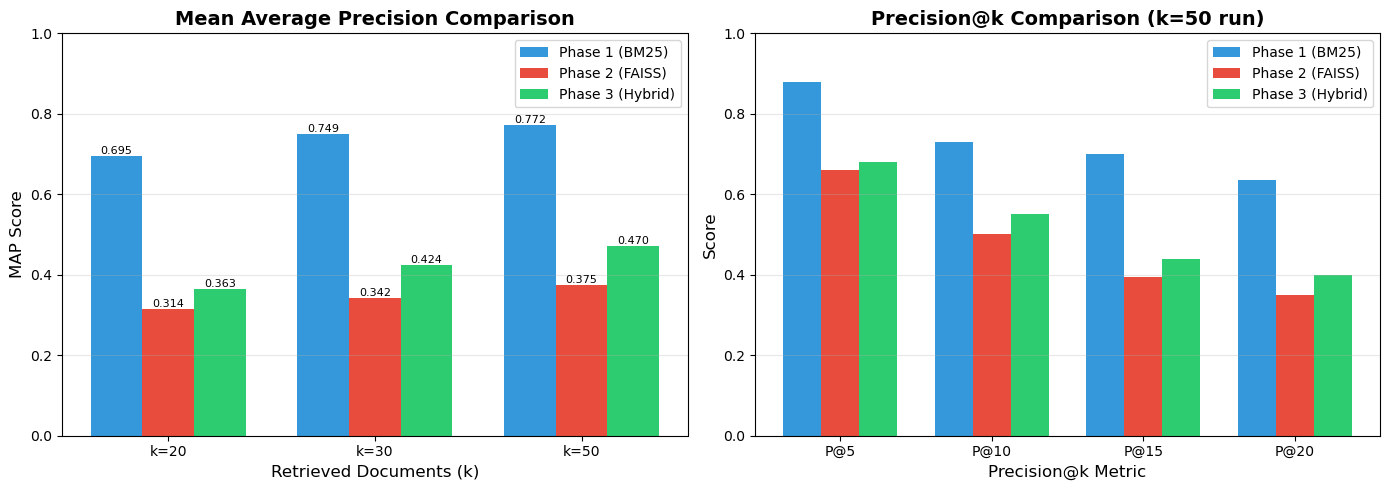

ΤΕΛΙΚΑ ΑΠΟΤΕΛΕΣΜΑΤΑ - PHASE 3 HYBRID SYSTEM
------------------------------------------------------------
             MAP      P@5     P@10     P@15     P@20
Run (k)                                             
20      0.363400 0.680000 0.550000 0.440000 0.400000
30      0.424300 0.680000 0.550000 0.440000 0.400000
50      0.470300 0.680000 0.550000 0.440000 0.400000
------------------------------------------------------------

 Key performance indicators
 Best MAP:  0.4703 (47.03%)
 Best P@5:  0.6800 (68.00%)
 Best P@10: 0.5500 (55.00%)


In [18]:
# Αποτελέσματα Φάσης 1 
phase1_results = {
    20: {"MAP": 0.6949, "P@5": 0.88, "P@10": 0.73, "P@15": 0.70, "P@20": 0.635},
    30: {"MAP": 0.7486, "P@5": 0.88, "P@10": 0.73, "P@15": 0.70, "P@20": 0.635},
    50: {"MAP": 0.7716, "P@5": 0.88, "P@10": 0.73, "P@15": 0.70, "P@20": 0.635}
}

# Αποτελέσματα Φάσης 2 
phase2_results = {
    20: {"MAP": 0.3136, "P@5": 0.66, "P@10": 0.50, "P@15": 0.3933, "P@20": 0.35},
    30: {"MAP": 0.3416, "P@5": 0.66, "P@10": 0.50, "P@15": 0.3933, "P@20": 0.35},
    50: {"MAP": 0.3748, "P@5": 0.66, "P@10": 0.50, "P@15": 0.3933, "P@20": 0.35}
}

if all_results:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: MAP Comparison 
    ax1 = axes[0]
    k_labels = [f'k={k}' for k in K_VALUES_RUN]
    x = np.arange(len(k_labels))
    width = 0.25
    
    # Get MAP values for each phase
    map_phase1 = [phase1_results[k].get('MAP', 0) for k in K_VALUES_RUN]
    map_phase2 = [phase2_results[k].get('MAP', 0) for k in K_VALUES_RUN]
    map_hybrid = [all_results[k].get('MAP', 0) for k in K_VALUES_RUN if k in all_results]
    
    bars1 = ax1.bar(x - width, map_phase1, width, label='Phase 1 (BM25)', color='#3498db')
    bars2 = ax1.bar(x, map_phase2, width, label='Phase 2 (FAISS)', color='#e74c3c')
    bars3 = ax1.bar(x + width, map_hybrid, width, label='Phase 3 (Hybrid)', color='#2ecc71')
    
    ax1.set_xlabel('Retrieved Documents (k)', fontsize=12)
    ax1.set_ylabel('MAP Score', fontsize=12)
    ax1.set_title('Mean Average Precision Comparison', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(k_labels)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    ax1.set_ylim(0, 1)
    
    # Add value labels
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    # Plot 2: P@k Comparison for k=50 
    ax2 = axes[1]
    p_metrics = ['P@5', 'P@10', 'P@15', 'P@20']
    x2 = np.arange(len(p_metrics))
    
    # Use k=50 for comparison
    p_phase1 = [phase1_results[50].get(m, 0) for m in p_metrics]
    p_phase2 = [phase2_results[50].get(m, 0) for m in p_metrics]
    p_hybrid = [all_results[50].get(m, 0) for m in p_metrics] if 50 in all_results else [0]*len(p_metrics)
    bars1 = ax2.bar(x2 - width, p_phase1, width, label='Phase 1 (BM25)', color='#3498db')
    bars2 = ax2.bar(x2, p_phase2, width, label='Phase 2 (FAISS)', color='#e74c3c')
    bars3 = ax2.bar(x2 + width, p_hybrid, width, label='Phase 3 (Hybrid)', color='#2ecc71')
    ax2.set_xlabel('Precision@k Metric', fontsize=12)
    ax2.set_ylabel('Score', fontsize=12)
    ax2.set_title('Precision@k Comparison (k=50 run)', fontsize=14, fontweight='bold')
    ax2.set_xticks(x2)
    ax2.set_xticklabels(p_metrics)
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    ax2.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'hybrid_comparison_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # --- Summary Table ---
    print("ΤΕΛΙΚΑ ΑΠΟΤΕΛΕΣΜΑΤΑ - PHASE 3 HYBRID SYSTEM")
    print("-"*60)
    print(results_df.to_string(float_format=lambda x: f'{x:.6f}'))
    print("-"*60)
    
    # Key Performance Indicators
    print("\n Key performance indicators")
    best_map = max(all_results[k].get('MAP', 0) for k in all_results)
    best_p5 = max(all_results[k].get('P@5', 0) for k in all_results)
    best_p10 = max(all_results[k].get('P@10', 0) for k in all_results)
    print(f" Best MAP:  {best_map:.4f} ({best_map*100:.2f}%)")
    print(f" Best P@5:  {best_p5:.4f} ({best_p5*100:.2f}%)")
    print(f" Best P@10: {best_p10:.4f} ({best_p10*100:.2f}%)")
else:
    print("No results to visualize.")

### Αρχεία που δημιουργούνται:
- Αποτελέσματα υβριδικού συστήματος: `results_hybrid_k20.txt`, `results_hybrid_k30.txt`, `results_hybrid_k50.txt` 
- Αξιολόγηση με trec_eval: `evaluation_hybrid_k20.txt`, `evaluation_hybrid_k30.txt`, `evaluation_hybrid_k50.txt` 
- Σύγκριση αποτελεσμάτων με τις Φάσεις 1 & 2: `hybrid_comparison_results.png`